# ROB5002-41 *Introduction to SLAM*

 **Final Project**

Victoria Park Dataset (for more information such as vehicle modeling, dynamic model and measurement model see [link](https://www-personal.acfr.usyd.edu.au/nebot/victoria_park.htm).)

<img src = "https://www.researchgate.net/publication/225106837/figure/fig7/AS:668616529805327@1536422011812/FastSLAM-20-applied-to-the-Victoria-Park-Dataset.png" height = 300>

**DATASET** - *arranged in time-order*

Example of the dataset (note that gps is gt, it is not used for EFK but used only for evaluation):

     | data[0] =  ('gps', [time, zx_gt, zy_gt, ztheta_gt])
     | data[1] =  ('odometry', [time, ve, alpha])
     | data[2] =  ('odometry', [time, ve, alpha])
     | data[3] =  ('measurements', [time, d0, phi0, d1, phi1, ...])
     | data[4] =  ('odometry', [time, ve, alpha])
     | data[5] =  ('odometry', [time, ve, alpha])
     | data[6] =  ('gps', [time, zx_gt, zy_gt, ztheta_gt])
     | data[7] =  ('odometry', [time, ve, alpha])
     | data[8] =  ('odometry', [time, ve, alpha])
     | data[9] =  ('measurements', [time, d0, phi0, d1, phi1, ...])
     ...

# TODO

**1. data.npy**

*   Assume that all landmarks are static
*   implement EKF SLAM

<img src = "https://drive.google.com/uc?id=1ELl2QZ3D_-_LSzbHLD6l_Qs5LJ10i_jI" height = 500>



\


**2. data_dynamic.npy**

*   Assume that all the trees are going crazy, uprooting themselves and moving at a velocity of [0.05, 0.05].
*   Trees are starting to move from the beginning of the data (starts to move right after data[0])
*   implement EKF SLAM with consideration of these dynamic landmarks.

\

* **EX) with common EKF SLAM (left), with EKF SLAM for dynamic landmarks (right)**

<img src = "https://drive.google.com/uc?id=1E_EzqCIchZcV1O6YSE5rU_5LHXOIpbEA" width = 500>
<img src = "https://drive.google.com/uc?id=1EL75ntOpKoOvzH88XnT5yt-j-KFrrMQ5" width = 500>












**Things to Submit**

 - your code (based on this jupyter notebook)

 - Report (minimum requirement)
  - Include 'introduction', 'method', 'experiments' and 'conclusion'
  - Explain your code and the reasons behind your implementation choices.
  - Consider two cases: data.npy and data_dynamic.npy. Explain your strategy and report the results such as ATE and num_of_seen_landmarks. Explain your results.
  - Explain Q and R. What are these? Discuss the effect of Q and R.
  - Explain the limitation of SLAM in the aspect of the dynamic environment. Compare the number of landmarks of each cases. Discuss your results.
  - (Bonus) explain the function "compute_data_association". What does this function do? Why we need it? Why this function compute below? Discuss the limitation of this function.
  
            r = np.array(np.array(measurements[k][0:2]) - np.array(z_hat))
            S_inv = np.linalg.inv(np.matmul(np.matmul(H,SIGMA),np.transpose(H)) + R[:2,:2])
            MD = np.matmul(np.matmul(np.transpose(r),S_inv), r)

**Recommendation**
 - No need to implement additional functions or parameters
 - Refer to see the textbook, *5.1. EXTENDED KALMAN FILTER* and *6.2 EKF SLAM*

In [ ]:
# codes are started after this block

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

In [2]:
import sys
import pathlib
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.distributions import chi2
from tqdm.auto import tqdm

# declare your path
#your_project_path = os.path.join('/content/drive/MyDrive/2025_slam/2025slam_finalproj')

#os.chdir(your_project_path)

In [3]:
'''
  DO NOT MODIFY THIS BLOCK
'''
def solve_cost_matrix_heuristic(M):
    n_msmts = M.shape[0]
    result = []

    ordering = np.argsort(M.min(axis=1))

    for msmt in ordering:
        match = np.argmin(M[msmt,:])
        M[:, match] = 1e8
        result.append((msmt, match))

    return result

def compute_data_association(MU, SIGMA, num_of_seen_landmarks, measurements, R):
    def measurement_model(MU, landmark_id):
        z_x, z_y, z_theta = MU[:robot_dim]
        z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))
        m_x, m_y = MU[robot_dim + landmark_dim*landmark_id : robot_dim + landmark_dim*(landmark_id+1)]
        d = np.sqrt((m_x-z_x)**2 + (m_y-z_y)**2)
        phi = np.arctan2((m_y-z_y),(m_x-z_x)) - z_theta
        phi = np.arctan2(np.sin(phi), np.cos(phi))
        zhat = np.array([d, phi])

        H = np.zeros((2,MU.size))
        H[0,0] = -(m_x - z_x)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,0] = (m_y - z_y)/((m_x - z_x)**2+(m_y - z_y)**2)
        H[0,1] = -(m_y - z_y)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,1] = -(m_x - z_x)/((m_x - z_x)**2+(m_y - z_y)**2)
        H[0,2] = 0
        H[1,2] = -1
        H[0,1+2*(landmark_id+1)] = (m_x - z_x)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,1+2*(landmark_id+1)] = -(m_y - z_y)/((m_x-z_x)**2+(m_y-z_y)**2)
        H[0,2+2*(landmark_id+1)] = (m_y - z_y)/np.sqrt((m_x - z_x)**2+(m_y - z_y)**2)
        H[1,2+2*(landmark_id+1)] = (m_x-z_x)/((m_x-z_x)**2+(m_y-z_y)**2)

        return zhat, H

    if num_of_seen_landmarks == 0:
        # set association to init new landmarks for all measurements
        return np.array([-1 for m in measurements])

    A = np.full((len(measurements),len(measurements)),chi2.ppf(0.96, df=2))
    cost_mat = np.full((len(measurements), num_of_seen_landmarks), chi2.ppf(0.96, df=2))

    for k in range(0,len(measurements)):
        for j in range(0,num_of_seen_landmarks):
            z_hat,H = measurement_model(MU, j)
            # print(measurements[k][0:2])
            r = np.array(np.array(measurements[k][0:2]) - np.array(z_hat))
            S_inv = np.linalg.inv(np.matmul(np.matmul(H,SIGMA),np.transpose(H)) + R[:2,:2])
            MD = np.matmul(np.matmul(np.transpose(r),S_inv), r)
            cost_mat[k,j] = MD

    cost_mat_conc = np.concatenate((cost_mat, A), axis=1)
    temp1 = np.copy(cost_mat)
    results = solve_cost_matrix_heuristic(temp1)

    assoc = np.zeros(len(measurements),dtype = np.int32)
    for k in range(0, len(results)):
        # print(cost_mat[results[k][0],results[k][1]])
        if cost_mat_conc[results[k][0],results[k][1]] > chi2.ppf(0.99, df=2):
            assoc[results[k][0]] = -1
        elif cost_mat_conc[results[k][0],results[k][1]] >= chi2.ppf(0.95, df=2):
            assoc[results[k][0]] = -2
        else:
            assoc[results[k][0]] = results[k][1]

    return assoc

def cal_ate_rmse(state_history, gps_history):
    state_history = np.array(state_history)
    state_history_t = state_history[:,0]

    max_dt = 0.015 # [s]    0.015
    ATE_errors = []
    # associated idxs
    idxs_gps = []
    idxs_est = []

    for i, gps in enumerate(gps_history):
        gps_t = gps[0]
        gps_xy = gps[1:3]

        # associate
        associated_idx = np.argmin(np.abs(state_history_t - gps_t))

        if np.abs(state_history_t[associated_idx] - gps_t) < max_dt:
            est_xy = state_history[associated_idx][1:3]
            ATE_error = (gps_xy[0] - est_xy[0])**2 + (gps_xy[1] - est_xy[1])**2
            ATE_errors.append(ATE_error)
            idxs_est.append(associated_idx)
            idxs_gps.append(i)

    ATE_errors = np.array(ATE_errors)
    ATE_RMSE = np.sqrt(np.mean(ATE_errors))
    print(f"ATE RMSE: {ATE_RMSE:.3f}[m]")
    return ATE_RMSE, idxs_gps, idxs_est

In [4]:
''' Do not modify these parameters '''
# parameters
robot_dim = 3
landmark_dim = 2
num_of_total_landmarks = 200 # assumed to be known

vehicle_params = {
        "a": 3.78,
        "b": 0.50,
        "L": 2.83,
        "H": 0.76
    }

In [5]:
def g_dynamic(z, u, dT, vehicle_params):

  #print('State before: ', z)
  z_new = z.copy()
  z_theta = z_new[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))  # normalize angle

  a = vehicle_params['a']
  b = vehicle_params['b']
  L = vehicle_params['L']
  H = vehicle_params['H']

  ve = u[0]
  alpha = u[1]
  vc = ve/(1 - np.tan(alpha)*H/L)

  dyn_model = np.array([
    dT * (vc * np.cos(z_theta) - vc / L * np.tan(alpha) * (a * np.sin(z_theta) + b * np.cos(z_theta))),
    dT * (vc * np.sin(z_theta) + vc / L * np.tan(alpha) * (a * np.cos(z_theta) - b * np.sin(z_theta))),
    dT * vc / L * np.tan(alpha)
    ])

  #print('Dynamic model: ', dyn_model)
  z_new[:3] += dyn_model
  
  for i in range(num_of_total_landmarks):
    idx = 3 + i * 2
    z_new[idx]     += dT * 0.05  # x component
    z_new[idx + 1] += dT * 0.05  # y component
  
  return z_new

def g_jacobian(z, u, dT, vehicle_params):

  z_theta = z[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))

  a = vehicle_params['a']
  b = vehicle_params['b']
  L = vehicle_params['L']
  H = vehicle_params['H']

  ve = u[0]
  alpha = u[1]
  vc = ve/(1 - np.tan(alpha)*H/L)

  G13 = -dT*vc*(np.sin(z_theta)+(1/L)*np.tan(alpha)*(a*np.cos(z_theta)-b*np.sin(z_theta)))
  G23 = dT*vc*(np.cos(z_theta)-(1/L)*np.tan(alpha)*(a*np.sin(z_theta)+b*np.cos(z_theta)))
  g_jacob = np.array([[1, 0, G13], [0, 1, G23],[0, 0, 1]])
  return g_jacob

def h_measurement(z, landmark_index, h_measurement_out):
#def h_measurement(z, landmark_index):
  z_x = z[0]
  z_y = z[1]
  z_theta = z[2]
  z_theta = np.arctan2(np.sin(z_theta), np.cos(z_theta))

  m_x = z[robot_dim + landmark_dim*landmark_index]
  m_y = z[robot_dim + landmark_dim*landmark_index + 1]

  del_x = m_x - z_x
  del_y = m_y - z_y
  r = del_x**2 + del_y**2
  sqrt_r = np.sqrt(r)
  new_theta = np.arctan2(del_y,del_x)-z_theta
  new_theta = np.arctan2(np.sin(new_theta), np.cos(new_theta))
  zhat = [[sqrt_r],[new_theta]]

  h_measurement_out[0] = zhat[0]
  h_measurement_out[1] = zhat[1]

  return h_measurement_out

#def h_jacobian(z, landmark_index, h_jacob):
def h_jacobian(z, landmark_index):

  z_x = z[0]
  z_y = z[1]

  m_x = z[robot_dim + landmark_dim*landmark_index]
  m_y = z[robot_dim + landmark_dim*landmark_index + 1]

  del_x = m_x - z_x
  del_y = m_y - z_y
  r = del_x**2 + del_y**2
  sqrt_r = np.sqrt(r)

  h = np.array([[-sqrt_r*del_x, -sqrt_r*del_y, 0, sqrt_r*del_x, sqrt_r*del_y],[del_y, -del_x, -r, -del_y, del_x]])/r
  F_x = np.zeros((5, len(z)))
  F_x[:3,:3] = np.eye(3)
  F_x[3,3+2*landmark_index]=1
  F_x[4,4+2*landmark_index]=1
  h_jacob = np.matmul(h,F_x)

  return h_jacob

# def h_jacobian(z, landmark_index, h_jacob):
#   #print(z.shape)
#   #print(z)
#   print('Landmark index:', landmark_index)
#   z_x = z[0]
#   z_y = z[1]

#   m_x = z[robot_dim + landmark_dim*landmark_index]
#   m_y = z[robot_dim + landmark_dim*landmark_index + 1]

#   del_x = m_x - z_x
#   del_y = m_y - z_y
#   delta = np.sqrt(del_x**2 + del_y**2)
#   h_jacob = np.array([[-del_x, -del_y, 0, del_x, del_y]/delta,
#                       [del_y/delta**2, -del_x/delta**2, -1, -del_y/delta**2, del_x/delta**2],
#                       ])
#   return h_jacob

In [25]:
'''
  you can modify these matrices if necessary
'''
# Dynamic noise
Q = np.diag(np.append(np.array([0.05**2, # variance of robot x
                                0.05**2, # variance of robot y
                   (0.5*np.pi/180)**2]), # variance of robot theta
              np.zeros((landmark_dim * num_of_total_landmarks,))))
print('Q shape: ', Q.shape)
# Measurement noise
# R = np.diag([0.5**2,          # variance of landmark r
#             (5*np.pi/180)**2] # variance of landmark theta
#                     * num_of_total_landmarks)

R = np.diag([0.1**2, (1*np.pi/180)**2])
print('R shape:', R.shape)

Q shape:  (1003, 1003)
R shape: (2, 2)


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 3.935[m]
num_trees 343


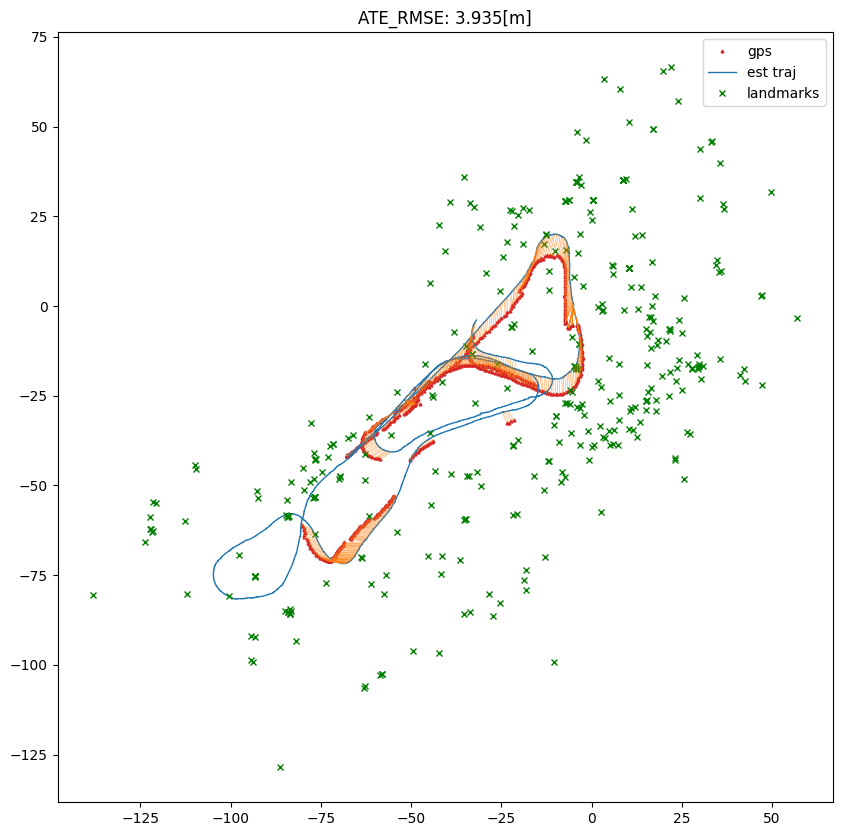

In [29]:
###########################################################################
# main
###########################################################################
# Reading dataset
# events, robot_init_pose = read_data(len_data=10000, path=your_data_path)

events, robot_init_pose = np.load('data_dynamic.npy', allow_pickle=True)
#print('Init robot position:', robot_init_pose)

'''
  it takes about 10 minuts for all trajectory estimation.
  for debuging you can crop the events as the following:
'''
#events = events[:5000] #

time_prev = -1
gps_history = []
state_history = {
    'robot_pose_history': [],
    'x': np.array(robot_init_pose),
    'P': np.array([.1, .1, 1])
}

# MU, SIGMA
MU = np.append(robot_init_pose, np.zeros((landmark_dim * num_of_total_landmarks, )))
SIGMA = np.diag(np.append(1 * np.ones((robot_dim, )),
                          100 * np.ones((landmark_dim * num_of_total_landmarks, ))))
num_of_seen_landmarks = 0

for i, event in tqdm(enumerate(events), total=len(events)):
    #print('Event:', event)
    time_curr = event[1][0]

    if event[0] == 'odometry':
        #print('Odometry event:', event[1])
        ## For the first data
        if time_prev < 0:
            time_prev = time_curr
            continue
        ##

        # Dynamic Update
        u = event[1][1:]    # u_t = [u_v, u_w]
        #print('Odometry event:', u)
        dT = time_curr - time_prev
        MU = g_dynamic(MU, u, dT, vehicle_params)
        #print("MU SHAPE", MU.shape)
        g_jacob = g_jacobian(MU, u, dT, vehicle_params)
        SIGMA[0:3, 0:3] = g_jacob @ SIGMA[0:3, 0:3] @ g_jacob.T + Q[0:3, 0:3]

        time_prev = time_curr
        #current_txy = [event[1][0], ekf_state['x'][0], ekf_state['x'][1]]

    elif event[0] == 'measurements':
        #print('Measurements event:', event[1])
        #print(i, 'th event, time:', time_curr)
        # measurements of the currently seen landmarks from current scan: (range, angle, diameter)
        x_list_curr = np.reshape(event[1][1:], [-1,3])

        # find data association informations
        # associations[i] ==  j if measurement i is associated with landmark j,
        # associations[i] == -1 if measurement i is determined to be a new, previously unseen landmark, or,
        # associations[i] == -2 if measurement i is too ambiguous to use and should be discarded.
        associations = compute_data_association(MU, SIGMA,
                                         num_of_seen_landmarks,
                                         x_list_curr, R)

        #print('Associations: ', associations)

        # update the measurements x, update the landmark indices, and update the states of the newly seen landmarks
        x = np.zeros((landmark_dim*num_of_total_landmarks,))
        x_landmark_indices = []
        #print(x_list_curr)
        for x_curr, association in zip(x_list_curr, associations):
          z_x, z_y, z_theta = MU[0:3]
          d, phi, _ = x_curr # _, d, phi = x_curr
          #print('Curr landm position:', x_curr)
          #print('Distance to landmark:', d)
          #print('angle of landmark:', phi)
          if association == -2: # Outlier, ignore it
            continue
          elif association== -1: # new landmark
            # update x
            x_landmark_indices.append(num_of_seen_landmarks)
            x[landmark_dim*num_of_seen_landmarks] = d
            x[landmark_dim*num_of_seen_landmarks+1] = phi
            # new landmark, init landmark state
            m_x = z_x + d*np.cos(z_theta + phi)
            m_y = z_y + d*np.sin(z_theta + phi)
            MU[robot_dim + landmark_dim * num_of_seen_landmarks] += m_x
            MU[robot_dim + landmark_dim * num_of_seen_landmarks + 1] += m_y
            num_of_seen_landmarks += 1
            #continue
          else:
            predicted_z = h_measurement(MU, association, np.zeros((2, 1)))
            #print('Association:', association)
            #print("Predicted:", predicted_z.ravel(), "Actual:", x_curr[:2])
            # update x
            x_landmark_indices.append(association)
            x[landmark_dim*association] = d
            x[landmark_dim*association+1] = phi

            #print('Robot state:', MU)
            #print('Landmark number:', association)
            h_measurement_out = np.zeros((2, 1))
            h_measurement_out = h_measurement(MU, association, h_measurement_out)
            h_jacob = h_jacobian(MU, association)

            #print('SIGMA shape:', SIGMA.shape)
            #print('R shape:', R.shape)
            #print('h_jacob shape:', h_jacob.shape)
            #print('h_measurement_out shape:', h_measurement_out.shape)

            # innovation = np.array([[d], [phi]]) - h_measurement_out
            # if np.linalg.norm(innovation) > 30:  # threshold depends on expected noise
            #     print(f"🚫 Skipping update due to large innovation: {innovation.ravel()}")
            #     continue

            K = SIGMA @ h_jacob.T @ np.linalg.inv(h_jacob @ SIGMA @ h_jacob.T + R)
            MU = MU + (K @ (np.array([[d], [phi]]) - h_measurement_out)).flatten()
            SIGMA = SIGMA - K @ h_jacob @ SIGMA

    elif event[0] == 'gps':
        gps_history.append(event[1][:3])
        continue

    state_history['x'] = np.vstack((state_history['x'], MU[0:3]))
    #print('State history:', state_history['x'][-1])
    state_history['P'] = np.vstack((state_history['P'], np.diag(SIGMA[:3,:3])))
    state_history['robot_pose_history'].append([time_prev, MU[0], MU[1]])

# end of data
ATE_RMSE, idxs_gps, idxs_est = cal_ate_rmse(state_history['robot_pose_history'], gps_history)

# plot results
plt.cla()
plt.rcParams['figure.figsize'] = [10, 10]
## GPS
gps_history = np.array(gps_history)
plt.plot(gps_history[:,1], gps_history[:,2], '^', markersize=2, color='tab:red', label='gps')
## Estimated Traj
plt.plot(state_history['x'][:,0], state_history['x'][:,1], color='tab:blue', linewidth=1, label='est traj')
## Landmarks
trees_plot = np.array(MU[3:]).reshape(-1,2)
plt.plot(trees_plot[:,0], trees_plot[:,1], 'xg', markersize=4, label='landmarks')

## Optional, to check associations between est traj and gps datas
for i in range(len(idxs_gps)):
    plt.plot(   [state_history['x'][idxs_est[i],0], gps_history[idxs_gps[i],1]],\
                [state_history['x'][idxs_est[i],1], gps_history[idxs_gps[i],2]],\
                color='tab:orange', linewidth=0.3)

print("num_trees", num_of_seen_landmarks)

plt.title(f"ATE_RMSE: {ATE_RMSE:.3f}[m]")
plt.legend()
plt.show()

In [6]:
def run_ekf_slam(Q, R):
  events, robot_init_pose = np.load('data.npy', allow_pickle=True)
  #print('Init robot position:', robot_init_pose)

  '''
    it takes about 10 minuts for all trajectory estimation.
    for debuging you can crop the events as the following:
  '''
  #events = events[:5000] #

  time_prev = -1
  gps_history = []
  state_history = {
      'robot_pose_history': [],
      'x': np.array(robot_init_pose),
      'P': np.array([.1, .1, 1])
  }

  # MU, SIGMA
  MU = np.append(robot_init_pose, np.zeros((landmark_dim * num_of_total_landmarks, )))
  SIGMA = np.diag(np.append(1 * np.ones((robot_dim, )),
                            100 * np.ones((landmark_dim * num_of_total_landmarks, ))))
  num_of_seen_landmarks = 0

  for i, event in tqdm(enumerate(events), total=len(events)):
      #print('Event:', event)
      time_curr = event[1][0]

      if event[0] == 'odometry':
          #print('Odometry event:', event[1])
          ## For the first data
          if time_prev < 0:
              time_prev = time_curr
              continue
          ##

          # Dynamic Update
          u = event[1][1:]    # u_t = [ve, alpha]
          #print('Odometry event:', u)
          dT = time_curr - time_prev
          MU = g_dynamic(MU, u, dT, vehicle_params)
          #print("MU SHAPE", MU.shape)
          g_jacob = g_jacobian(MU, u, dT, vehicle_params)
          SIGMA[0:3, 0:3] = g_jacob @ SIGMA[0:3, 0:3] @ g_jacob.T + Q[0:3, 0:3]

          time_prev = time_curr
          #current_txy = [event[1][0], ekf_state['x'][0], ekf_state['x'][1]]

      elif event[0] == 'measurements':
          #print('Measurements event:', event[1])
          #print(i, 'th event, time:', time_curr)
          # measurements of the currently seen landmarks from current scan: (range, angle, diameter)
          x_list_curr = np.reshape(event[1][1:], [-1,3])

          # find data association informations
          # associations[i] ==  j if measurement i is associated with landmark j,
          # associations[i] == -1 if measurement i is determined to be a new, previously unseen landmark, or,
          # associations[i] == -2 if measurement i is too ambiguous to use and should be discarded.
          associations = compute_data_association(MU, SIGMA,
                                          num_of_seen_landmarks,
                                          x_list_curr, R)

          #print('Associations: ', associations)

          # update the measurements x, update the landmark indices, and update the states of the newly seen landmarks
          x = np.zeros((landmark_dim*num_of_total_landmarks,))
          x_landmark_indices = []
          #print(x_list_curr)
          for x_curr, association in zip(x_list_curr, associations):
            z_x, z_y, z_theta = MU[0:3]
            d, phi, _ = x_curr # _, d, phi = x_curr
            #print('Curr landm position:', x_curr)
            #print('Distance to landmark:', d)
            #print('angle of landmark:', phi)
            if association == -2: # Outlier, ignore it
              continue
            elif association== -1: # new landmark
              # update x
              x_landmark_indices.append(num_of_seen_landmarks)
              x[landmark_dim*num_of_seen_landmarks] = d
              x[landmark_dim*num_of_seen_landmarks+1] = phi
              # new landmark, init landmark state
              m_x = z_x + d*np.cos(z_theta + phi)
              m_y = z_y + d*np.sin(z_theta + phi)
              MU[robot_dim + landmark_dim * num_of_seen_landmarks] += m_x
              MU[robot_dim + landmark_dim * num_of_seen_landmarks + 1] += m_y
              num_of_seen_landmarks += 1
              #continue
            else:
              predicted_z = h_measurement(MU, association, np.zeros((2, 1)))
              #print('Association:', association)
              #print("Predicted:", predicted_z.ravel(), "Actual:", x_curr[:2])
              # update x
              x_landmark_indices.append(association)
              x[landmark_dim*association] = d
              x[landmark_dim*association+1] = phi

              #print('Robot state:', MU)
              #print('Landmark number:', association)
              h_measurement_out = np.zeros((2, 1))
              h_measurement_out = h_measurement(MU, association, h_measurement_out)
              h_jacob = h_jacobian(MU, association)

              #print('SIGMA shape:', SIGMA.shape)
              #print('R shape:', R.shape)
              #print('h_jacob shape:', h_jacob.shape)
              #print('h_measurement_out shape:', h_measurement_out.shape)

              # innovation = np.array([[d], [phi]]) - h_measurement_out
              # if np.linalg.norm(innovation) > 30:  # threshold depends on expected noise
              #     print(f"🚫 Skipping update due to large innovation: {innovation.ravel()}")
              #     continue

              K = SIGMA @ h_jacob.T @ np.linalg.inv(h_jacob @ SIGMA @ h_jacob.T + R)
              MU = MU + (K @ (np.array([[d], [phi]]) - h_measurement_out)).flatten()
              SIGMA = SIGMA - K @ h_jacob @ SIGMA

      elif event[0] == 'gps':
          gps_history.append(event[1][:3])
          continue

      state_history['x'] = np.vstack((state_history['x'], MU[0:3]))
      #print('State history:', state_history['x'][-1])
      state_history['P'] = np.vstack((state_history['P'], np.diag(SIGMA[:3,:3])))
      state_history['robot_pose_history'].append([time_prev, MU[0], MU[1]])

  # end of data
  ATE_RMSE, idxs_gps, idxs_est = cal_ate_rmse(state_history['robot_pose_history'], gps_history)

  output_dir = "ekf_slam_dynamic"
  os.makedirs(output_dir, exist_ok=True)

  # Plot results
  plt.cla()
  plt.rcParams['figure.figsize'] = [10, 10]

  # GPS trajectory
  gps_history = np.array(gps_history)
  plt.plot(gps_history[:,1], gps_history[:,2], '^', markersize=2, color='tab:red', label='gps')

  # Estimated robot trajectory
  plt.plot(state_history['x'][:,0], state_history['x'][:,1], color='tab:blue', linewidth=1, label='est traj')

  # Landmarks
  trees_plot = np.array(MU[3:]).reshape(-1,2)
  plt.plot(trees_plot[:,0], trees_plot[:,1], 'xg', markersize=4, label='landmarks')

  # Optionally show GPS vs estimated association lines
  for i in range(len(idxs_gps)):
      plt.plot([state_history['x'][idxs_est[i],0], gps_history[idxs_gps[i],1]],
              [state_history['x'][idxs_est[i],1], gps_history[idxs_gps[i],2]],
              color='tab:orange', linewidth=0.3)

  # Title includes RMSE and number of landmarks
  plt.title(f"ATE_RMSE: {ATE_RMSE:.3f} [m] | Seen Landmarks: {num_of_seen_landmarks}")
  plt.legend()

  # Save the figure
  filename = f"slam_result_rmse_{ATE_RMSE:.3f}_landmarks_{num_of_seen_landmarks}.png"
  save_path = os.path.join(output_dir, filename)
  plt.savefig(save_path, dpi=200)
  plt.close()
  
  return ATE_RMSE, num_of_seen_landmarks

In [7]:
from bayes_opt import BayesianOptimization

def run_slam_with_params(q_x, q_y, q_theta, r_range, r_bearing):
    
    # Construct Q and R
    robot_noise = np.array([q_x**2, q_y**2, q_theta**2])
    landmark_noise = np.zeros(landmark_dim * num_of_total_landmarks)
    full_noise = np.append(robot_noise, landmark_noise)
    Q = np.diag(full_noise)
    R = np.diag([r_range**2, r_bearing**2])

    try:
        ATE_RMSE, num_seen_landmarks = run_ekf_slam(Q, R)

        if num_seen_landmarks > num_of_total_landmarks:
            return -1e6  # Hard penalty

        alpha = 0.5  # Example weight
        score = -ATE_RMSE + alpha * (num_seen_landmarks / num_of_total_landmarks)
        return score

    except Exception as e:
        print(f"❌ Error in SLAM run: {e}")
        return -1e6  # Handle crash safely

pbounds = {
    'q_x': (0.001, 0.1),             # slightly larger range
    'q_y': (0.001, 0.1),
    'q_theta': (np.radians(0.1), np.radians(2)),  # in radians
    'r_range': (0.1, 1.0),           # reasonable real-world sensor range noise
    'r_bearing': (np.radians(0.5), np.radians(10))
}

optimizer = BayesianOptimization(
    f=run_slam_with_params,
    pbounds=pbounds,
    random_state=42,
)

# Start optimization
optimizer.maximize(
    init_points=7,   # Random initial trials
    n_iter=10,       # Number of Bayesian steps
)


print("Best parameters found:")
print(optimizer.max)

|   iter    |  target   |    q_x    |    q_y    |  q_theta  |  r_range  | r_bearing |
-------------------------------------------------------------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 10.446[m]
| 2         | -9.980558 | 0.0380794 | 0.0951207 | 0.0260191 | 0.6387926 | 0.0345955 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 3         | -1000000. | 0.0164434 | 0.0067502 | 0.0304688 | 0.6410035 | 0.1261295 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 4         | -1000000. | 0.0030378 | 0.0970210 | 0.0293501 | 0.2911051 | 0.0388743 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 72.731[m]
| 5         | -72.24118 | 0.0191570 | 0.0311199 | 0.0191469 | 0.4887505 | 0.0570142 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 72.826[m]
| 6         | -72.33051 | 0.0615734 | 0.0148098 | 0.0114332 | 0.4297256 | 0.0843459 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 7         | -1000000. | 0.0787324 | 0.0207677 | 0.0187979 | 0.6331731 | 0.0164284 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 68.423[m]
| 8         | -67.92560 | 0.0611469 | 0.0178818 | 0.0039025 | 0.9539969 | 0.1688345 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 11.018[m]
| 9         | -10.52059 | 0.0275041 | 0.0279064 | 0.0176265 | 0.4771241 | 0.0623945 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 12.614[m]
| 10        | -12.23415 | 0.0561131 | 0.0275196 | 0.0167587 | 0.8012804 | 0.1294076 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 10.074[m]
| 11        | -9.704177 | 0.0619594 | 0.0801645 | 0.0118523 | 0.8848594 | 0.1255534 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 100.382[m]
| 12        | -99.94194 | 0.001     | 0.001     | 0.0349065 | 0.8921767 | 0.0970854 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 10.994[m]
| 13        | -10.54872 | 0.0523585 | 0.0648566 | 0.0065234 | 0.4718474 | 0.1127687 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 14        | -1000000. | 0.001     | 0.1       | 0.0319055 | 0.7971600 | 0.0243376 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 107.766[m]
| 15        | -107.3531 | 0.1       | 0.001     | 0.0349065 | 0.8654760 | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 16        | -1000000. | 0.1       | 0.001     | 0.0017453 | 0.9212364 | 0.0706779 |


  0%|          | 0/10000 [00:00<?, ?it/s]

❌ Error in SLAM run: index 400 is out of bounds for axis 0 with size 400
| 17        | -1000000. | 0.0106630 | 0.0319409 | 0.0263311 | 0.8734195 | 0.1745329 |


  0%|          | 0/10000 [00:00<?, ?it/s]

ATE RMSE: 9.471[m]
| 18        | -9.096359 | 0.0972742 | 0.0474652 | 0.0212095 | 0.8413810 | 0.1394019 |
Best parameters found:
{'target': np.float64(-9.096359816450523), 'params': {'q_x': np.float64(0.0972742109022591), 'q_y': np.float64(0.04746520129604828), 'q_theta': np.float64(0.021209591746621494), 'r_range': np.float64(0.8413810855145691), 'r_bearing': np.float64(0.139401957990475)}}
